In [12]:
import numpy as np
import math
from astropy.convolution import Gaussian2DKernel, Kernel2D, Moffat2DKernel
from astropy.modeling import models
from astropy.constants import h,c,k_B
import matplotlib.pyplot as plt
import scipy

h = h.value
c = c.value
k_B = k_B.value

def _round_up_to_odd_integer(value):
    i = math.ceil(value)
    if i % 2 == 0:
        return i + 1
    else:
        return i
    
class Moffat2DKernel2(Kernel2D):

    _is_bool = False

    def __init__(self, amplitude, x_0, y_0, gamma, alpha, **kwargs):
        self._model = models.Moffat2D(amplitude, x_0, y_0, gamma, alpha)
        #print(self._model.fwhm)
        self._default_size = _round_up_to_odd_integer(4.0 * self._model.fwhm)
        super().__init__(**kwargs)
        #self.normalize()
        self._truncation = None



def moffat_scarlet(y, x, alpha=4.7, beta=1.5, bbox=None, oversample_factor=1):
    """Symmetric 2D Moffat function
    .. math::
        (1+\frac{(x-x0)**2+(y-y0)**2}{alpha**2})**{-beta}
    Parameters
    ----------
    y: float
        Vertical coordinate of the center
    x: float
        Horizontal coordinate of the center
    alpha: float
        Core width
    beta: float
        Power-law index
    bbox: Box
        Bounding box over which to evaluate the function
    Returns
    -------
    result: array
        A 2D circular gaussian sampled at the coordinates `(y_i, x_j)`
        for all i and j in `shape`.
    """
    Y = (numpy.linspace(0, bbox.shape[1], num=bbox.shape[1]*oversample_factor) + bbox.origin[1])
    Y = (numpy.linspace(0, bbox.shape[2], num=bbox.shape[2]*oversample_factor) + bbox.origin[2])

    X, Y = np.meshgrid(X, Y)

    return ((1 + ((X - x) ** 2 + (Y - y) ** 2) / alpha ** 2) ** -beta)[None, :, :]

 
        
def blackbody(l,T=10000):
    '''
    Inputs
    ------
    l in angstrom
    T in kelvin
    '''
    l = l*1e-10 # converting to meters
    bb = 2*h*c**2/l**5*(1/(np.exp(h*c/(l*k_B*T))-1))*1e-22
    bb /= bb.sum()
    return bb

def moffat(seeing, amplitude = None, center = (0,0),mode=None,factor=None, size=None):
    alpha = 3.5
    gamma = 0.5 * seeing / np.sqrt(2**(1./alpha) - 1.)
    if amplitude == None:
        amplitude = (alpha - 1.0) / (np.pi * gamma * gamma)
    moff = Moffat2DKernel2(amplitude,
                            center[0],
                            center[1],
                            gamma,
                            alpha,
                            x_size=size,
                            mode=mode,
                            factor=factor)
    return moff.array

def gaussian(seeing):
    morph = Gaussian2DKernel(seeing).array
    return morph

def spectral_source(spectra,morph):
    cube = np.outer(spectra.T, morph)
    cube.shape = (len(spectra), morph.shape[0], morph.shape[1])
    return cube



In [13]:
wl = np.arange(3470.0,5542.0,2)
temps = np.linspace(4000,10000,20)
print(temps[4])
bbs = []
for T in temps:
    bbs.append(blackbody(wl, T))
bbs = np.array(bbs)

5263.157894736842


28.9324 27.2638 3.41 3.255 82.99


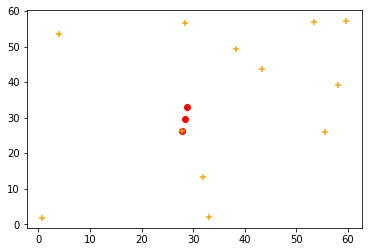

[[ 1.00000000e+00  4.40850300e+05  4.08754200e+03 -1.41107000e+01
   1.01000000e-02  7.17967800e+03  2.89324000e+01  2.72638000e+01
   1.06086937e+01  1.16153112e+01  1.25589395e-01  3.41000000e+00
   3.25500000e+00  8.29900000e+01  2.80000000e-02]
 [ 2.00000000e+00  1.10194300e+05  4.43530200e+03 -1.26054000e+01
   4.37000000e-02  1.02233500e+03  3.29174000e+01  1.42972000e+01
   8.87307625e+00  4.39660814e+00 -2.06998532e+00  3.11200000e+00
   1.89400000e+00 -2.13800000e+01  1.00000000e-03]
 [ 3.00000000e+00  3.55852800e+04  2.14856700e+03 -1.13782000e+01
   6.56000000e-02  1.06523800e+03  3.39809000e+01  3.16250000e+00
   2.19682471e+00  1.99043381e+00 -1.53436843e-01  1.50900000e+00
   1.38200000e+00 -2.80400000e+01  5.06000000e-01]
 [ 4.00000000e+00  2.48304600e+04  8.56981800e+02 -1.09875000e+01
   3.75000000e-02  3.40677600e+03  1.70110000e+00  2.92290000e+00
   5.17288585e-01  2.18366298e+00 -4.04804943e-02  1.47800000e+00
   7.19000000e-01 -8.86100000e+01  7.14000000e-01]
 [ 5

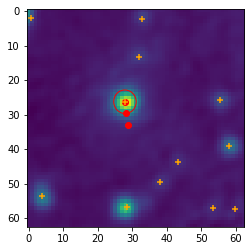

In [51]:
from astropy.io import fits
import numpy as np
import os 
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.pyplot as plt

ecube="/home/majoburo/Work/GWHET-paper/cubes/20191214_0000023_047_error_cube.fits"
ccube="/home/majoburo/Work/GWHET-paper/cubes/20191214_0000023_047cutout.fits"
cube="/home/majoburo/Work/GWHET-paper/cubes/20191214_0000023_047_cube.fits"


def getsex(fname):
    os.chdir("../config")
    os.system("sextractor "+fname)
    sexdata = np.loadtxt('test.cat')
    os.chdir("../junk")
    return sexdata

def kn_in_gal(sexdata, ccube, plot = False):
    #GET GALACTIC SHAPE PARAMS
    cdata = sexdata[np.all((sexdata[:,6:8]<63/2+5)*
                           (sexdata[:,6:8]>63/2-5),axis=1)]
    if len(cdata) > 1:
        cdata = np.argmin(cdata[:,-1])
    if len(cdata) == 0:
        raise("No galaxy within central radius. Is this a transient follow-up?")
    a,b,theta = cdata[11:14]
    
    #Copy the cube
    hdu = fits.open(cube)    
    #place kn in different positions
    for i in range(3):
        x1 = x+(i)*a*np.cos(theta*np.pi/180)-1
        y1 = y+(i)*a*np.sin(theta*np.pi/180)-1
        morph = moffat(2.2*1/0.75,amplitude=30,center=(x1[i]-63/2+1/2,y1[i]-63/2+1/2),mode='oversample',factor=20,size=63)
        #make kn of different temperatures
        for T in [4000,7000,11000]:
            bb = blackbody(wl, T)
            kn = spectral_source(bb,morph)
            hduu = hdu.__deepcopy__()
            hduu[0].data = hduu[0].data + kn
            kn0 = path+"/kn_"+i+"_"+T+"_"+file
            hduu.writeto(kn0, overwrite=True)
            #dont stop till we find the points
            while 
                points = getsex(fname)
                x,y,dx2,dy2= points[:,6:10].T
                

            if plot:
                fig, ax = plt.subplots()
                ellipse = Ellipse((0,0),
                        width = a * 2,
                        height = b * 2,
                        facecolor = 'none',
                        edgecolor = 'red')
                transf = transforms.Affine2D() \
                        .rotate_deg(theta)\
                        .translate(x-1,y-1)

                ellipse.set_transform(transf + ax.transData)
                ax.imshow(chduu[0].data)
                ax.add_patch(ellipse)
                ax.imshow((hduu[0].data + kn).sum(axis=0))
                plt.scatter(x1,y1,color="red")
                plt.show()
    return


ellipse = Ellipse((0,0),
        width = a * 2,
        height = b * 2,
        facecolor = 'none',
        edgecolor = 'red')
transf = transforms.Affine2D() \
        .rotate_deg(theta)\
        .translate(x-1,y-1)

ellipse.set_transform(transf + ax.transData)
#ax.imshow(chduu[0].data)
ax.add_patch(ellipse)
x1,y1=[],[]
noise = np.zeros(chduu[0].data.shape)
for i in range(3):
    x1.append(x+(i)*a*np.cos(theta*np.pi/180)-1)
    y1.append(y+(i)*a*np.sin(theta*np.pi/180)-1)
    noise += moffat(2.2*1/0.75,amplitude=30,center=(x1[i]-63/2+1/2,y1[i]-63/2+1/2),mode='oversample',factor=20,size=63)
ax.imshow(chduu[0].data + noise)
#ax.imshow(noise)

plt.scatter(x1,y1,color="red")
plt.scatter(sexdata[:,6]-1,sexdata[:,7]-1,c='orange',marker='+')
plt.show()


#path,file = os.path.split(cube)
#kn0 = path+"/kn0_"+file
hdu = fits.open(cube)

#chdu = fits.open(ccube)
#chduu = chdu.__deepcopy__()
#chduu[0].data = chdu[0].data#.sum(axis=0)
#chduu.writeto(kn0, overwrite=True)
sexdata = getsex(ccube)

fig, ax = plt.subplots()
print(sexdata)
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
x,y=sexdata[0,6:8]
a,b,theta=sexdata[0,11:14]
print(x,y,a,b,theta)
ellipse = Ellipse((0,0),
        width=a * 2,
        height=b * 2,
        facecolor='none',
        edgecolor='red')
transf = transforms.Affine2D() \
        .rotate_deg(theta)\
        .translate(x-1,y-1)

ellipse.set_transform(transf + ax.transData)
#ax.imshow(chduu[0].data)
ax.add_patch(ellipse)
x1,y1=[],[]
noise = np.zeros(chduu[0].data.shape)
for i in range(3):
    x1.append(x+i*a*np.cos(theta*np.pi/180)-1)
    y1.append(y+i*a*np.sin(theta*np.pi/180)-1)
    noise += moffat(2.2*1/0.75,amplitude=30,center=(x1[i]-63/2+1/2,y1[i]-63/2+1/2),mode='oversample',factor=20,size=63)
ax.imshow(chduu[0].data + noise)
#ax.imshow(noise)

plt.scatter(x1,y1,color="red")
plt.scatter(sexdata[:,6]-1,sexdata[:,7]-1,c='orange',marker='+')
plt.show()




In [65]:
sexdata[np.all((sexdata[:,6:8]<63/2+5)*(sexdata[:,6:8]>63/2-5),axis=1)].shape

(1, 15)

In [147]:
def detectable(amp,x1,y1,bb,hdu,kn0):
    #Ugly ass function
    morph = moffat(2.2*1/0.75,amplitude=amp,center=(x1-63/2+1/2,y1-63/2+1/2),mode='oversample',factor=20,size=63)
    kn = spectral_source(bb,morph)
    hduu = hdu.__deepcopy__()
    hduu[0].data = hduu[0].data + kn
    hduu.writeto(kn0, overwrite=True)
    plt.imshow((hduu[0].data).sum(axis=0))
    points = getsex(kn0)
    x,y,dx2,dy2 = points[:,6:10].T
    x=x-1
    y=y-1
    plt.scatter(x,y)
    plt.show()
    ar = np.argmin((x-x1)**2+(y-y1)**2)
    print(x[ar],x1,y[ar],y1,dx2[ar],dy2[ar])
    return np.any(np.sqrt((x-x1)**2+(y-y1)**2) <= 1)


In [149]:
def kn_in_gal(sexdata, ccube, plot = False):
    #GET GALACTIC SHAPE PARAMS
    cdata = sexdata[np.all((sexdata[:,6:8]<63/2+5)*
                           (sexdata[:,6:8]>63/2-5),axis=1)]
    if len(cdata) > 1:
        cdata = np.argmin(cdata[:,-1])
    if len(cdata) == 0:
        raise("No galaxy within central radius. Is this a transient follow-up?")
    a,b,theta = cdata[0][11:14]
    x,y = cdata[0][6:8]
    
    #Copy the cube
    hdu = fits.open(cube)    
    #place kn in different positions and temperatures
    for T in [4000,7000,11000]:
        bb = blackbody(wl, T)
        for i in range(1,4):
            x1 = x+(i)*a*np.cos(theta*np.pi/180)-1
            y1 = y+(i)*a*np.sin(theta*np.pi/180)-1
            kn0 = "%s/kn_%d_%d_%s"%(path,i,T,file)
            binary_search(x1,y1,bb,hdu,kn0,low=10,high=1000)
            
            if plot:
                sexdataplot = np.loadtxt('../config/test.cat')
                xp,yp = sexdata[:,6:8].T
                #a,b,theta = sexdata[0,11:14]
                fig, ax = plt.subplots()
                #ellipse = Ellipse((0,0),
                #        width = a * 2,
                #        height = b * 2,
                #        facecolor = 'none',
                #        edgecolor = 'red')
                #transf = transforms.Affine2D() \
                #        .rotate_deg(theta)\
                #        .translate(x-1,y-1)

                #ellipse.set_transform(transf + ax.transData)
                ax.imshow(hdu[0].data.sum(axis=0))
                #ax.add_patch(ellipse)
                #ax.imshow((hduu[0].data + kn).sum(axis=0))
                plt.scatter(xp-1,yp-1,color="white")
                plt.show()
    return

def binary_search(x1,y1,bb,hdu,kn0,low=10,high=1000):
    #def detectable(i):
    #return i > num
    #low = 10
    #high = 1000
    amp = (high + low)/2
    iterations = 0
    num_iterations = int(np.log(high-low)/np.log(2))
    while iterations < num_iterations:
        print(amp)
        if detectable(amp,x1,y1,bb,hdu,kn0):
            high = amp
        else:
            low = amp
        amp = (high+low)/2
        iterations +=1
    return

505.0


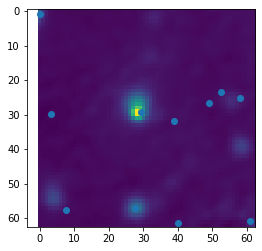

29.2476 28.348565175741847 29.2148 29.64830979412082 6.5453051668 3.8739335273
257.5


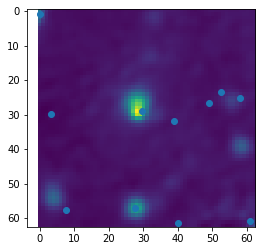

29.6506 28.348565175741847 28.9911 29.64830979412082 7.959838119 3.9526905833
381.25


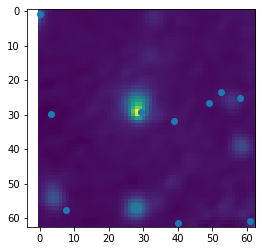

29.3904 28.348565175741847 29.1477 29.64830979412082 7.1968774803 3.8235427148
443.125


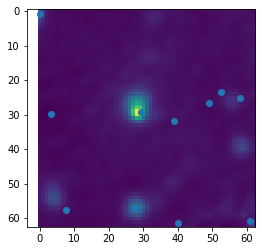

29.2881 28.348565175741847 29.1828 29.64830979412082 6.901495064 3.8649158197
474.0625


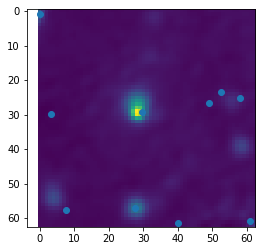

29.638 28.348565175741847 29.3178 29.64830979412082 9.8179373772 4.020797979
489.53125


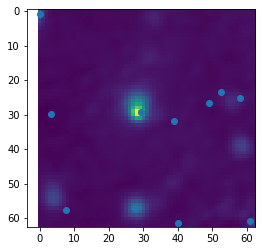

29.2648 28.348565175741847 29.2074 29.64830979412082 6.6151303 3.8695542105
497.265625


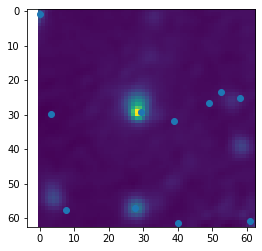

29.2561 28.348565175741847 29.2112 29.64830979412082 6.5828793203 3.8611280116
501.1328125


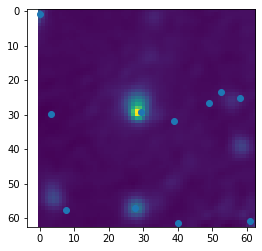

29.2518 28.348565175741847 29.213 29.64830979412082 6.5610425111 3.8779552426
503.06640625


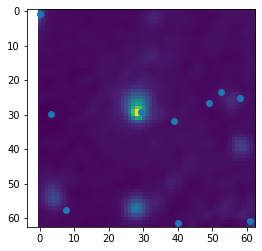

29.2497 28.348565175741847 29.2139 29.64830979412082 6.5534953489 3.8761676949


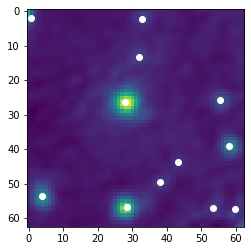

505.0


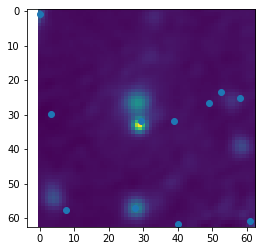

29.4927 28.764730351483696 31.736600000000003 33.032819588241644 6.1972939202 7.822854157
752.5


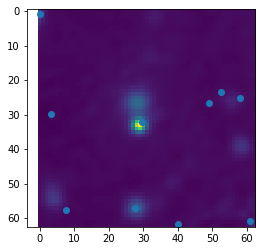

29.5655 28.764730351483696 32.0065 33.032819588241644 7.7952210134 6.8525513898
876.25


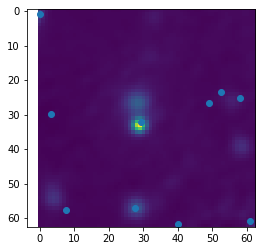

29.48 28.764730351483696 32.1287 33.032819588241644 7.3413412951 6.598542935
938.125


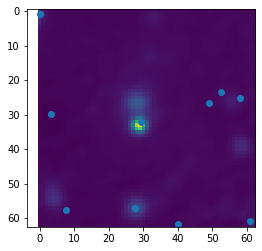

29.4461 28.764730351483696 32.1749 33.032819588241644 7.138812824 6.4578676659
969.0625


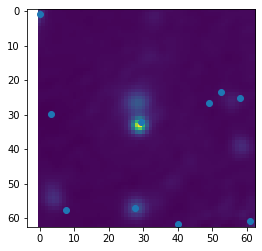

29.424 28.764730351483696 32.1978 33.032819588241644 7.0683140795 6.3937573623
984.53125


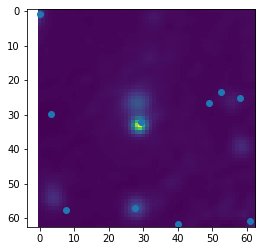

29.4162 28.764730351483696 32.2082 33.032819588241644 7.0205670232 6.3599203321
992.265625


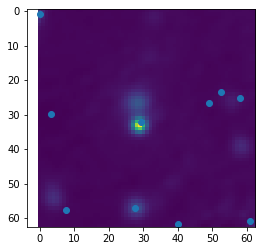

29.4127 28.764730351483696 32.213 33.032819588241644 7.0010296778 6.3455264449
996.1328125


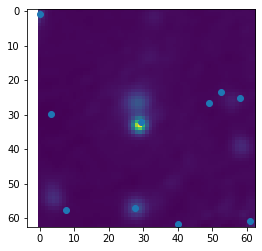

29.4108 28.764730351483696 32.2154 33.032819588241644 6.9903267143 6.3377902083
998.06640625


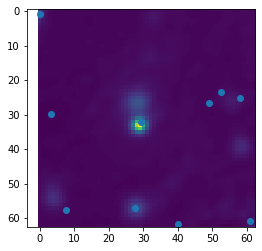

29.4099 28.764730351483696 32.2167 33.032819588241644 6.9846319325 6.3337217623


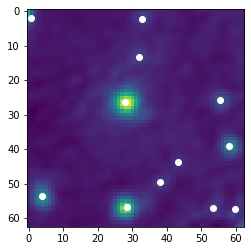

505.0


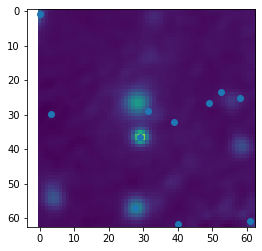

29.1497 29.18089552722554 36.4188 36.41732938236246 3.0329316989 2.8046145016
257.5


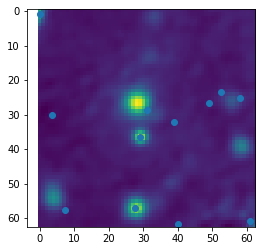

29.0967 29.18089552722554 36.4194 36.41732938236246 2.6447138705 2.4768786007
133.75


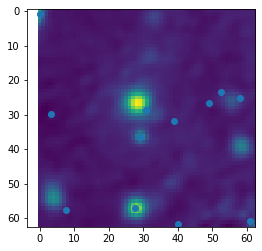

29.0864 29.18089552722554 36.4081 36.41732938236246 2.3025656991 2.1053483387
71.875


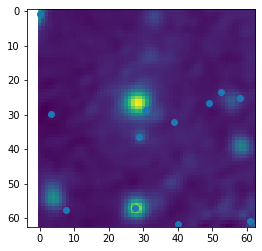

28.8318 29.18089552722554 36.3923 36.41732938236246 1.8017155437 1.6827098934
40.9375


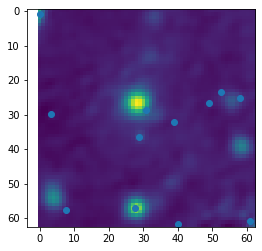

28.7823 29.18089552722554 36.3821 36.41732938236246 1.5329419597 0.9219024367
25.46875


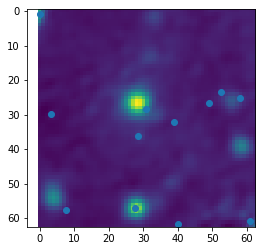

28.4987 29.18089552722554 36.2646 36.41732938236246 0.99697290872 0.75025153573
17.734375


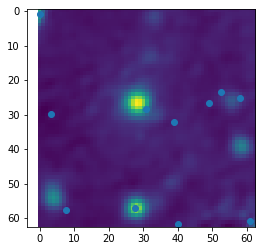

30.9095 29.18089552722554 28.4963 36.41732938236246 13.198666353 5.0694758358
21.6015625


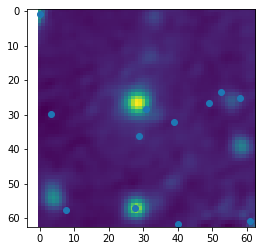

28.6635 29.18089552722554 36.1583 36.41732938236246 0.83545428153 0.49779212885
19.66796875


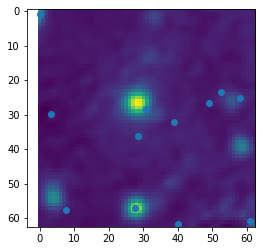

28.5048 29.18089552722554 36.3344 36.41732938236246 0.83100878149 0.22256646824


KeyboardInterrupt: 

In [150]:
kn_in_gal(sexdata, ccube, plot = True)
